#Assignment 03
#Muhammad Ali Reg no 329159
##MS DS 2k20 Computer Vision

###Training U-Net Models Inceptionv3 vs EfficientNetB7

##Installing Libraries

In [1]:
!pip install te
!pip install keras.utils
!pip install -U segmentation-models
!pip install -U --pre segmentation-models

     |████████████████████████████████| 227 kB 5.2 MB/s 
     |████████████████████████████████| 489 kB 42.3 MB/s 
     |████████████████████████████████| 125 kB 57.5 MB/s 
     |████████████████████████████████| 156 kB 51.0 MB/s 
     |████████████████████████████████| 58 kB 6.5 MB/s 
     |████████████████████████████████| 141 kB 53.1 MB/s 
     |████████████████████████████████| 81 kB 10.1 MB/s 
     |████████████████████████████████| 57 kB 5.9 MB/s 
  Attempting uninstall: six
    Found existing installation: six 1.15.0
    Uninstalling six-1.15.0:
      Successfully uninstalled six-1.15.0
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: python-dateutil
    Found existing installation: python-dateutil 2.8.2
    Uninstalling python-dateutil-2.8.2:
      Successfully uninstalled python-dateutil-2.8.2
  Attempting uninstall: idna
    Found existing inst

  Created wheel for keras.utils: filename=keras_utils-1.0.13-py3-none-any.whl size=2656 sha256=2e5dc7840b40526479f5bb92ac741362d4333c62e591323671ddfd136bb27141
  Stored in directory: /root/.cache/pip/wheels/d0/dd/3b/493952a5240d486a83805d65360dedadbadeae71d25e2c877f
Successfully built keras.utils
     |████████████████████████████████| 50 kB 4.3 MB/s 


##Importing Libraries

In [2]:
import tensorflow as tf
import segmentation_models as sm
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import keras 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import normalize
from tensorflow.keras.metrics import MeanIoU

Segmentation Models: using `keras` framework.


In [3]:
sm.set_framework('tf.keras')

sm.framework()

'tf.keras'

##Mounting Google Drive and setting path

In [4]:
SIZE_X = 224 #Resize images (height  = X, width = Y)
SIZE_Y = 224
n_classes=12 #Number of classes for segmentation

from google.colab import drive
drive.mount('/content/drive')
train_path_imgs = 'drive/My Drive/Datasets/SemSegDataSet/images_prepped_train'
test_path_imgs = 'drive/My Drive/Datasets/SemSegDataSet/images_prepped_test'
train_path_y = 'drive/My Drive/Datasets/SemSegDataSet/annotations_prepped_train'
test_path_y = 'drive/My Drive/Datasets/SemSegDataSet/annotations_prepped_test'

Mounted at /content/drive


##Reading Images Data

In [5]:

train_images = []

for directory_path in glob.glob(train_path_imgs):
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        img = cv2.imread(img_path, 1)       
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        img = img / 255.0
        img = img.astype(np.float32)
        train_images.append(img)
          
train_images = np.array(train_images)

train_masks = [] 
for directory_path in glob.glob(train_path_y):
    for mask_path in glob.glob(os.path.join(directory_path, "*.png")):
        mask = cv2.imread(mask_path, 0)       
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)
        mask = mask.astype(np.int32)  
        train_masks.append(mask)
               
train_masks = np.array(train_masks)


test_images = []

for directory_path in glob.glob(test_path_imgs):
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        img = cv2.imread(img_path, 1)       
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        img = img / 255.0
        img = img.astype(np.float32)
        test_images.append(img)
               
test_images = np.array(test_images)

test_masks = [] 
for directory_path in glob.glob(test_path_y):
    for mask_path in glob.glob(os.path.join(directory_path, "*.png")):
        mask = cv2.imread(mask_path, 0)       
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)
        mask = mask.astype(np.int32)
        test_masks.append(mask)
                
test_masks = np.array(test_masks)


In [12]:
test_masks.shape

(101, 224, 224)

##Encoding Labels

In [7]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
n1, h1, w1 = test_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)
test_masks_reshaped = test_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
test_masks_reshaped_encoded = labelencoder.fit_transform(test_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)
test_masks_encoded_original_shape = test_masks_reshaped_encoded.reshape(n1, h1, w1)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


##Expanding Dimession

In [8]:

train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)
test_masks_input = np.expand_dims(test_masks_encoded_original_shape, axis=3)

## Spliting Validation Data

In [9]:

from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(train_images, train_masks_input, test_size=0.2, random_state=42)

## Converting Catagorical Labels

In [10]:

train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2],n_classes))

val_masks_cat = to_categorical(y_val, num_classes=n_classes)
y_val_cat = val_masks_cat.reshape((y_val.shape[0], y_val.shape[1], y_val.shape[2],n_classes))

test_masks_cat = to_categorical(test_masks_input, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((test_masks_input.shape[0], test_masks_input.shape[1], test_masks_input.shape[2],n_classes))

In [14]:
y_test_cat.shape

(101, 224, 224, 12)

##Setting Compiling Parameters

In [ ]:
activation='softmax'

LR = 0.0001
optim = tf.keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.083333333,0.083333333,0.083333333,0.083333333,0.083333333,0.083333333,0.083333333,0.083333333,0.083333333,0.083333333,0.083333333,0.083333333])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

In [ ]:
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

##Setting Framework to Tensorflow Keras

## Loading and Compiling U-Net Model1 Backbone Inceptionv3

In [ ]:
BACKBONE1 = 'inceptionv3'
preprocess_input1 = sm.get_preprocessing(BACKBONE1)

# preprocess input
X_train1 = preprocess_input1(x_train)
X_test1 = preprocess_input1(test_images)
X_val1 = preprocess_input1(x_val)

# define model
model1 = sm.Unet(BACKBONE1, encoder_weights='imagenet', classes=n_classes, activation=activation)

# compile keras model with defined optimozer, loss and metrics
model1.compile(optim, total_loss, metrics=metrics)

#model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

print(model1.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d_94 (Conv2D)             (None, None, None,   864         ['input_2[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization_94 (BatchN  (None, None, None,   96         ['conv2d_94[0][0]']              
 ormalization)                  32)                                                         

##Training U-net Inception 

In [ ]:
history1=model1.fit(X_train1, 
          y_train_cat,
          batch_size=8, 
          epochs=50,
          verbose=1,
          validation_data=(X_val1,y_val_cat))

Epoch 1/50
37/37 [==============================] - 70s 2s/step - loss: 1.0255 - iou_score: 0.0014 - f1-score: 0.0026 - val_loss: 1.0322 - val_iou_score: 3.5346e-05 - val_f1-score: 7.0654e-05
Epoch 2/50
37/37 [==============================] - 59s 2s/step - loss: 1.0118 - iou_score: 0.0581 - f1-score: 0.0836 - val_loss: 1.0273 - val_iou_score: 7.7343e-08 - val_f1-score: 1.5029e-07
Epoch 3/50
37/37 [==============================] - 59s 2s/step - loss: 1.0055 - iou_score: 0.1123 - f1-score: 0.1487 - val_loss: 1.0216 - val_iou_score: 0.0136 - val_f1-score: 0.0250
Epoch 4/50
37/37 [==============================] - 59s 2s/step - loss: 1.0020 - iou_score: 0.1384 - f1-score: 0.1810 - val_loss: 1.0226 - val_iou_score: 0.0292 - val_f1-score: 0.0453
Epoch 5/50
37/37 [==============================] - 59s 2s/step - loss: 0.9983 - iou_score: 0.1619 - f1-score: 0.2081 - val_loss: 1.0241 - val_iou_score: 0.0407 - val_f1-score: 0.0626
Epoch 6/50
37/37 [==============================] - 59s 2s/step 

##Saving Model

In [ ]:
model1.save('inceptionv3_backbone_50epochs.hdf5')

## Saving Loss IOU Score F1 Score Graphs

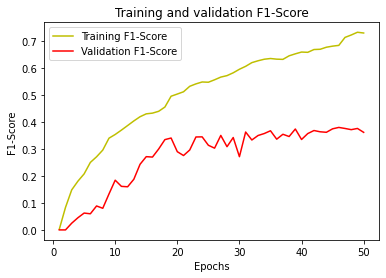

<Figure size 432x288 with 0 Axes>

In [ ]:
f1score = history1.history['f1-score']
val_f1score = history1.history['val_f1-score']
epochs = range(1, len(f1score) + 1)
plt.plot(epochs, f1score, 'y', label='Training F1-Score')
plt.plot(epochs, val_f1score, 'r', label='Validation F1-Score')
plt.title('Training and validation F1-Score')
plt.xlabel('Epochs')
plt.ylabel('F1-Score')
plt.legend()
plt.show()
plt.savefig("F1-score-Inception.svg")

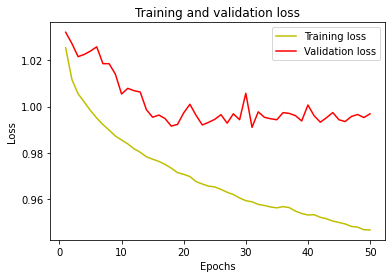

<Figure size 432x288 with 0 Axes>

In [ ]:
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.savefig("loss-Inception.svg")


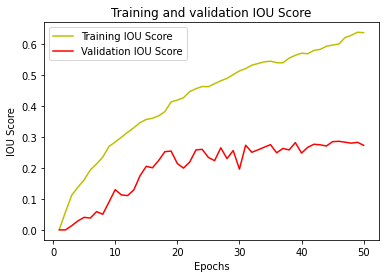

<Figure size 432x288 with 0 Axes>

In [ ]:

score = history1.history['iou_score']
val_score = history1.history['val_iou_score']
epochs = range(1, len(score) + 1)
plt.plot(epochs, score, 'y', label='Training IOU Score')
plt.plot(epochs, val_score, 'r', label='Validation IOU Score')
plt.title('Training and validation IOU Score')
plt.xlabel('Epochs')
plt.ylabel('IOU Score')
plt.legend()
plt.show()
plt.savefig("IOUscore-Inception.svg")

##Moving Model and plots into GoogleDrive

In [ ]:
import shutil
shutil.move("inceptionv3_backbone_50epochs.hdf5", "drive/My Drive/Model_H5_Files/")
shutil.move("F1-score-Inception.svg", "drive/My Drive/Model_H5_Files/")
shutil.move("loss-Inception.svg", "drive/My Drive/Model_H5_Files/")
shutil.move("IOUscore-Inception.svg", "drive/My Drive/Model_H5_Files/")


'drive/My Drive/Model_H5_Files/IOUscore-Inception.svg'

## Loading and Compiling U-Net Model2 Backbone EfficientNetB7

In [ ]:
BACKBONE2 = 'efficientnetb7'
preprocess_input2 = sm.get_preprocessing(BACKBONE2)

X_train2 = preprocess_input2(x_train)
X_test2 = preprocess_input2(test_images)
X_val2 = preprocess_input2(x_val)

model2 = sm.Unet(BACKBONE2, encoder_weights='imagenet', classes=n_classes, activation=activation)

model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

print(model2.summary())

258449408/258434480 [==============================] - 9s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 stem_conv (Conv2D)             (None, None, None,   1728        ['input_1[0][0]']                
                                64)                                                               
                                                                                                  
 stem_bn (BatchNormalization)   (None, None, None,   256         ['stem_conv[0][0]']              
                           

In [ ]:
X_val2.shape

(74, 224, 224, 3)

##Training Model2 U-Net EfficientB7

In [ ]:
history2=model2.fit(X_train2, 
          y_train_cat,
          batch_size=8, 
          epochs=50,
          verbose=1,
          validation_data=(X_val2,y_val_cat))

Epoch 1/50
37/37 [==============================] - 274s 6s/step - loss: 1.8014 - iou_score: 0.0474 - f1-score: 0.0637 - val_loss: 7.0031 - val_iou_score: 0.0886 - val_f1-score: 0.1132
Epoch 2/50
37/37 [==============================] - 224s 6s/step - loss: 1.1908 - iou_score: 0.1182 - f1-score: 0.1524 - val_loss: 4.5434 - val_iou_score: 0.1331 - val_f1-score: 0.1691
Epoch 3/50
37/37 [==============================] - 210s 6s/step - loss: 1.1324 - iou_score: 0.1316 - f1-score: 0.1670 - val_loss: 2.6009 - val_iou_score: 0.1289 - val_f1-score: 0.1669
Epoch 4/50
37/37 [==============================] - 194s 5s/step - loss: 1.0991 - iou_score: 0.1284 - f1-score: 0.1624 - val_loss: 2.0589 - val_iou_score: 0.1286 - val_f1-score: 0.1678
Epoch 5/50
37/37 [==============================] - 196s 5s/step - loss: 1.0591 - iou_score: 0.1396 - f1-score: 0.1741 - val_loss: 1.4898 - val_iou_score: 0.1388 - val_f1-score: 0.1755
Epoch 6/50
37/37 [==============================] - 197s 5s/step - loss: 1.

##Saving Model2

In [ ]:
model2.save('efficientnetb7_backbone_50epochs.hdf5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


## Saving Loss IOU Score and F1 Score Graph

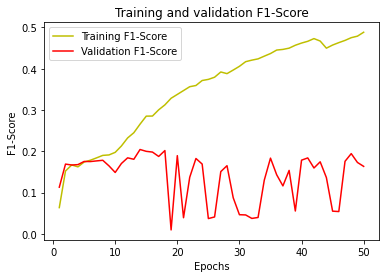

<Figure size 432x288 with 0 Axes>

In [ ]:
f1score = history2.history['f1-score']
val_f1score = history2.history['val_f1-score']
epochs = range(1, len(f1score) + 1)
plt.plot(epochs, f1score, 'y', label='Training F1-Score')
plt.plot(epochs, val_f1score, 'r', label='Validation F1-Score')
plt.title('Training and validation F1-Score')
plt.xlabel('Epochs')
plt.ylabel('F1-Score')
plt.legend()
plt.show()
plt.savefig("F1-score-efficient.svg")

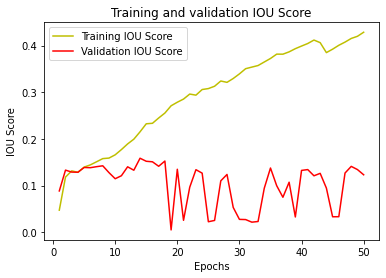

<Figure size 432x288 with 0 Axes>

In [ ]:

score = history2.history['iou_score']
val_score = history2.history['val_iou_score']
epochs = range(1, len(score) + 1)
plt.plot(epochs, score, 'y', label='Training IOU Score')
plt.plot(epochs, val_score, 'r', label='Validation IOU Score')
plt.title('Training and validation IOU Score')
plt.xlabel('Epochs')
plt.ylabel('IOU Score')
plt.legend()
plt.show()
plt.savefig("IOUscore-efficient.svg")

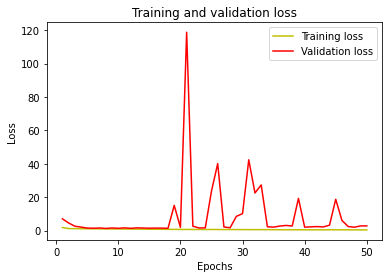

<Figure size 432x288 with 0 Axes>

In [ ]:
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.savefig("loss-efficient.svg")


##Moving Graph and Models to Google Drive

In [ ]:
import shutil
shutil.move("efficientnetb7_backbone_50epochs.hdf5", "drive/My Drive/Model_H5_Files/")
shutil.move("loss-efficient.svg", "drive/My Drive/Model_H5_Files/")
shutil.move("IOUscore-efficient.svg", "drive/My Drive/Model_H5_Files/")
shutil.move("F1-score-efficient.svg", "drive/My Drive/Model_H5_Files/")

'drive/My Drive/Model_H5_Files/F1-score-efficient.svg'

## Evaluating Results

In [ ]:
result1 = model1.evaluate(X_test1, y_test_cat , verbose=1)

4/4 [==============================] - 3s 579ms/step - loss: 1.0016 - iou_score: 0.1480 - f1-score: 0.1902


In [ ]:
result2 = model2.evaluate(X_test2, y_test_cat , verbose=1)


4/4 [==============================] - 7s 2s/step - loss: 3.3788 - iou_score: 0.1088 - f1-score: 0.1482


## Prediction

In [ ]:
predict1 = model1.predict(X_test1)
predict2 = model2.predict(X_test1)


##Normalizing Prediction

In [ ]:
result22 = np.zeros((predict2.shape[0],predict2.shape[1],predict2.shape[2]),dtype='int')
for n in range(predict2.shape[0]):
  for x in range(predict2.shape[1]):
    for y in range(predict2.shape[2]):
      temp = np.argmax(predict2[n,x,y],axis=0)
      result22[n,x,y]=temp

In [ ]:
result11 = np.zeros((predict1.shape[0],predict1.shape[1],predict1.shape[2]),dtype='int')
for n in range(predict1.shape[0]):
  for x in range(predict1.shape[1]):
    for y in range(predict1.shape[2]):
      temp = np.argmax(predict1[n,x,y],axis=0)
      result11[n,x,y]=temp

In [ ]:
np.unique(result22)

array([0, 1])

In [ ]:
predict2.shape

(101, 224, 224, 12)

##Reading Images

In [ ]:
realtest_images = []

for directory_path in glob.glob(test_path_imgs):
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        img = cv2.imread(img_path, 1)       
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        realtest_images.append(img)
realtest_masks = [] 
for directory_path in glob.glob(test_path_y):
    for mask_path in glob.glob(os.path.join(directory_path, "*.png")):
        mask = cv2.imread(mask_path, 0)       
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)
        realtest_masks.append(mask)



##Prediction Qualitative Sample Using U-Net backbone inception V3

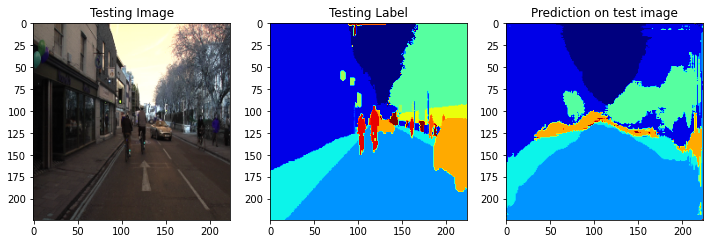

In [ ]:

test_img = realtest_images[1]
ground_truth = realtest_masks[1]
predicted_img = result11[1]
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth,cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img,cmap='jet')
plt.show()

##Prediction Qualitative Sample U-Net backcone EfficientNetB7

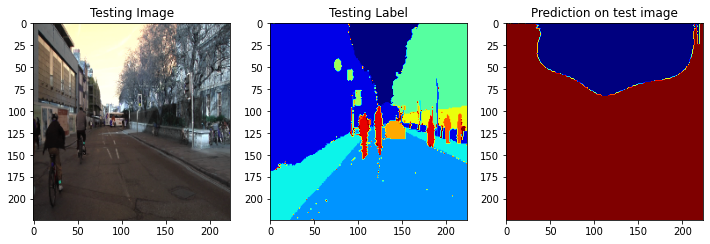

In [ ]:

test_img = realtest_images[0]
ground_truth = realtest_masks[0]
predicted_img = result22[0]
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth,cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img,cmap='jet')
plt.show()